### Experiment: Normalization

**Question**: Is normalization necessary? If so, what kind performs best?

**Hypothesis**: The data is already re-referenced using `mne.set_eeg_reference("average")` during pre-processing. The range used is approximately $[-55, 55]$, models might work better at a more commonly used range of $[0,1]$, or $[-1, 1]$ to keep negative numbers.

**Result**:

#### Part 1: Investigation

In [1]:
import xarray as xr
from xhistogram.xarray import histogram
import numpy as np
from pathlib import Path

In [6]:
data_path = Path("../data/sat1/split_stage_data.nc")
# data_path = Path("../data/ar/data.nc")
data = xr.load_dataset(data_path)

##### Histogram of distribution of all values

<xarray.DataArray 'histogram_data' (data_bin: 59)>
array([       2,        1,        0,        5,       15,       19,
             24,       32,       45,       61,      100,      158,
            253,      519,      867,     1583,     3230,     6714,
          15760,    38855,    97256,   250239,   634912,  1572221,
        3677891,  7561941, 11932895, 12228996,  8004789,  3907171,
        1684189,   701249,   298114,   131032,    58714,    27015,
          12419,     5919,     2804,     1380,      692,      298,
            154,       52,       25,       25,       18,       11,
              5,        3,        3,        2,        1,        3,
              3,        3,        0,        1,        2])
Coordinates:
  * data_bin  (data_bin) float64 -80.16 -77.14 -74.12 ... 88.9 91.92 94.94

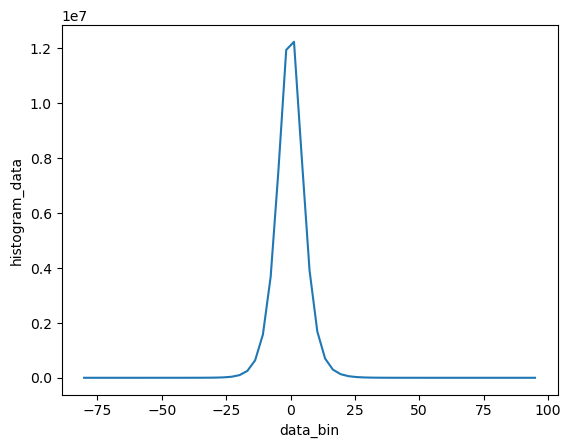

In [7]:
max = data.max().data.item()
min = data.min().data.item()
bins = np.linspace(min, max, 60)
hist = histogram(data.data, bins=bins, block_size=data.samples.size)
display(hist)
hist.plot()

##### Histogram of distribution for each channel

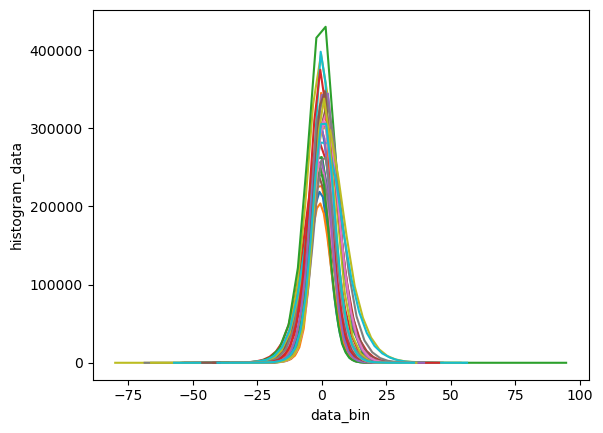

In [8]:
for channel in data.channels:
    data_subset = data.sel(channels=channel)
    max = data_subset.max().data.item()
    min = data_subset.min().data.item()
    bins = np.linspace(min, max, 40)
    hist = histogram(data_subset.data, bins=bins, block_size=data_subset.samples.size)
    hist.plot()

#### Part 2: Experiment

In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import xarray as xr
from hmpai.utilities import print_results
from hmpai.pytorch.models import *
from hmpai.pytorch.training import k_fold_cross_validate
from hmpai.normalization import *
from hmpai.data import SAT1_STAGES_ACCURACY
import json

In [2]:
data_path = Path("../data/sat1/split_stage_data.nc")

data = xr.load_dataset(data_path)

In [3]:
norm_fns = [norm_dummy, norm_0_to_1, norm_min1_to_1, norm_zscore]


def test_normalization(norm_fn):
    print(f"Testing norm_fn: {norm_fn.__name__}")
    model = SAT1GRU
    model_kwargs = {
        "n_channels": len(data.channels),
        "n_samples": len(data.samples),
        "n_classes": len(data.labels),
    }
    train_kwargs = {
        "logs_path": Path("../logs/exp_normalization_gru/"),
        "additional_info": {"norm_fn": norm_fn.__name__},
        "additional_name": f"norm_fn-{norm_fn.__name__}",
        "labels": SAT1_STAGES_ACCURACY,
    }
    result = k_fold_cross_validate(
        model,
        model_kwargs,
        data,
        k=25,
        normalization_fn=norm_fn,
        train_kwargs=train_kwargs,
    )
    with open(
        train_kwargs["logs_path"] / f"results_{norm_fn.__name__}.json", "w"
    ) as f:
        json.dump(result, f, indent=4)
    print_results(result)

In [4]:
test_normalization(norm_fns[0])

Testing norm_fn: norm_dummy
Fold 1: test fold: ['0009']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 1: Accuracy: 0.9193548387096774
Fold 1: F1-Score: 0.9189590478638655
Fold 2: test fold: ['0017']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 2: Accuracy: 0.9121540312876053
Fold 2: F1-Score: 0.9025428860739405
Fold 3: test fold: ['0001']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 3: Accuracy: 0.9324644549763034
Fold 3: F1-Score: 0.9297394289290478
Fold 4: test fold: ['0024']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 4: Accuracy: 0.836627140974967
Fold 4: F1-Score: 0.836697914316906
Fold 5: test fold: ['0012']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 5: Accuracy: 0.9248768472906403
Fold 5: F1-Score: 0.9241266291884175
Fold 6: test fold: ['0010']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 6: Accuracy: 0.8748466257668711
Fold 6: F1-Score: 0.8784285148394029
Fold 7: test fold: ['0014']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 7: Accuracy: 0.9042690815006468
Fold 7: F1-Score: 0.9057057119524584
Fold 8: test fold: ['0002']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 8: Accuracy: 0.9038238702201622
Fold 8: F1-Score: 0.8921159676082195
Fold 9: test fold: ['0023']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 9: Accuracy: 0.9471830985915493
Fold 9: F1-Score: 0.9426972513106886
Fold 10: test fold: ['0006']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 10: Accuracy: 0.879245283018868
Fold 10: F1-Score: 0.8758293413566214
Fold 11: test fold: ['0003']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 11: Accuracy: 0.9549436795994993
Fold 11: F1-Score: 0.9549060528176925
Fold 12: test fold: ['0013']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 12: Accuracy: 0.9286592865928659
Fold 12: F1-Score: 0.9309728717346563
Fold 13: test fold: ['0016']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 13: Accuracy: 0.8991793669402111
Fold 13: F1-Score: 0.9012248386433083
Fold 14: test fold: ['0004']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 14: Accuracy: 0.8837535014005602
Fold 14: F1-Score: 0.8848582287889718
Fold 15: test fold: ['0005']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 15: Accuracy: 0.9428223844282239
Fold 15: F1-Score: 0.9392833456687871
Fold 16: test fold: ['0021']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 16: Accuracy: 0.9404761904761905
Fold 16: F1-Score: 0.9390455145945186
Fold 17: test fold: ['0018']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 17: Accuracy: 0.9235436893203883
Fold 17: F1-Score: 0.9198482926913684
Fold 18: test fold: ['0022']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 18: Accuracy: 0.9288256227758007
Fold 18: F1-Score: 0.9265422288805676
Fold 19: test fold: ['0019']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 19: Accuracy: 0.9601449275362319
Fold 19: F1-Score: 0.9598112263179928
Fold 20: test fold: ['0025']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 20: Accuracy: 0.8938271604938272
Fold 20: F1-Score: 0.8968477639025977
Fold 21: test fold: ['0008']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 21: Accuracy: 0.933420365535248
Fold 21: F1-Score: 0.9320553452096181
Fold 22: test fold: ['0011']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 22: Accuracy: 0.925700365408039
Fold 22: F1-Score: 0.9251131491025688
Fold 23: test fold: ['0015']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 23: Accuracy: 0.9255813953488372
Fold 23: F1-Score: 0.9240732870736009
Fold 24: test fold: ['0020']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 24: Accuracy: 0.8993464052287582
Fold 24: F1-Score: 0.8950677656979513
Fold 25: test fold: ['0007']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 25: Accuracy: 0.889294403892944
Fold 25: F1-Score: 0.8878237386847555
Test set 0
Accuracies
[0.9193548387096774, 0.9121540312876053, 0.9324644549763034, 0.836627140974967, 0.9248768472906403, 0.8748466257668711, 0.9042690815006468, 0.9038238702201622, 0.9471830985915493, 0.879245283018868, 0.9549436795994993, 0.9286592865928659, 0.8991793669402111, 0.8837535014005602, 0.9428223844282239, 0.9404761904761905, 0.9235436893203883, 0.9288256227758007, 0.9601449275362319, 0.8938271604938272, 0.933420365535248, 0.925700365408039, 0.9255813953488372, 0.8993464052287582, 0.889294403892944]
F1-Scores
[0.9189590478638655, 0.9025428860739405, 0.9297394289290478, 0.836697914316906, 0.9241266291884175, 0.8784285148394029, 0.9057057119524584, 0.8921159676082195, 0.9426972513106886, 0.8758293413566214, 0.9549060528176925, 0.9309728717346563, 0.9012248386433083, 0.8848582287889718, 0.9392833456687871, 0.9390455145945186, 0.9198482926913684, 0.9265422288805676, 0.9598112263179928, 0.896847763902597

In [5]:
test_normalization(norm_fns[1])

Testing norm_fn: norm_0_to_1
Fold 1: test fold: ['0009']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 1: Accuracy: 0.9366359447004609
Fold 1: F1-Score: 0.9388138577179113
Fold 2: test fold: ['0017']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 2: Accuracy: 0.9253910950661853
Fold 2: F1-Score: 0.9215762706980462
Fold 3: test fold: ['0001']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 3: Accuracy: 0.9016587677725119
Fold 3: F1-Score: 0.8981059231558867
Fold 4: test fold: ['0024']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 4: Accuracy: 0.8801054018445322
Fold 4: F1-Score: 0.884737006464861
Fold 5: test fold: ['0012']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 5: Accuracy: 0.9421182266009852
Fold 5: F1-Score: 0.944838292409494
Fold 6: test fold: ['0010']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 6: Accuracy: 0.905521472392638
Fold 6: F1-Score: 0.9105641839383976
Fold 7: test fold: ['0014']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 7: Accuracy: 0.890038809831824
Fold 7: F1-Score: 0.8901215000207987
Fold 8: test fold: ['0002']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 8: Accuracy: 0.9107763615295481
Fold 8: F1-Score: 0.9044797537452703
Fold 9: test fold: ['0023']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 9: Accuracy: 0.9730046948356808
Fold 9: F1-Score: 0.9719041756480473
Fold 10: test fold: ['0006']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 10: Accuracy: 0.8716981132075472
Fold 10: F1-Score: 0.8677145290728262
Fold 11: test fold: ['0003']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 11: Accuracy: 0.9499374217772215
Fold 11: F1-Score: 0.950135653534734
Fold 12: test fold: ['0013']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 12: Accuracy: 0.923739237392374
Fold 12: F1-Score: 0.9281297733507425
Fold 13: test fold: ['0016']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 13: Accuracy: 0.9062133645955451
Fold 13: F1-Score: 0.9100076302028193
Fold 14: test fold: ['0004']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 14: Accuracy: 0.9159663865546218
Fold 14: F1-Score: 0.9172604968101006
Fold 15: test fold: ['0005']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 15: Accuracy: 0.9549878345498783
Fold 15: F1-Score: 0.9556017208506077
Fold 16: test fold: ['0021']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 16: Accuracy: 0.9619047619047619
Fold 16: F1-Score: 0.9607118451666221
Fold 17: test fold: ['0018']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 17: Accuracy: 0.9429611650485437
Fold 17: F1-Score: 0.9435964349717182
Fold 18: test fold: ['0022']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 18: Accuracy: 0.9323843416370107
Fold 18: F1-Score: 0.9311366687539809
Fold 19: test fold: ['0019']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 19: Accuracy: 0.9698067632850241
Fold 19: F1-Score: 0.9695541013663018
Fold 20: test fold: ['0025']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 20: Accuracy: 0.9382716049382716
Fold 20: F1-Score: 0.9415732820059036
Fold 21: test fold: ['0008']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 21: Accuracy: 0.9569190600522193
Fold 21: F1-Score: 0.9543689821416572
Fold 22: test fold: ['0011']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 22: Accuracy: 0.9269183922046285
Fold 22: F1-Score: 0.9260994663591344
Fold 23: test fold: ['0015']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 23: Accuracy: 0.9255813953488372
Fold 23: F1-Score: 0.9202227583391351
Fold 24: test fold: ['0020']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 24: Accuracy: 0.9281045751633987
Fold 24: F1-Score: 0.9273401018395818
Fold 25: test fold: ['0007']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 25: Accuracy: 0.9355231143552312
Fold 25: F1-Score: 0.9355618456120685
Test set 0
Accuracies
[0.9366359447004609, 0.9253910950661853, 0.9016587677725119, 0.8801054018445322, 0.9421182266009852, 0.905521472392638, 0.890038809831824, 0.9107763615295481, 0.9730046948356808, 0.8716981132075472, 0.9499374217772215, 0.923739237392374, 0.9062133645955451, 0.9159663865546218, 0.9549878345498783, 0.9619047619047619, 0.9429611650485437, 0.9323843416370107, 0.9698067632850241, 0.9382716049382716, 0.9569190600522193, 0.9269183922046285, 0.9255813953488372, 0.9281045751633987, 0.9355231143552312]
F1-Scores
[0.9388138577179113, 0.9215762706980462, 0.8981059231558867, 0.884737006464861, 0.944838292409494, 0.9105641839383976, 0.8901215000207987, 0.9044797537452703, 0.9719041756480473, 0.8677145290728262, 0.950135653534734, 0.9281297733507425, 0.9100076302028193, 0.9172604968101006, 0.9556017208506077, 0.9607118451666221, 0.9435964349717182, 0.9311366687539809, 0.9695541013663018, 0.94157328200590

In [6]:
test_normalization(norm_fns[2])

Testing norm_fn: norm_min1_to_1
Fold 1: test fold: ['0009']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 1: Accuracy: 0.9412442396313364
Fold 1: F1-Score: 0.9425406186796635
Fold 2: test fold: ['0017']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 2: Accuracy: 0.9265944645006017
Fold 2: F1-Score: 0.92194606631211
Fold 3: test fold: ['0001']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 3: Accuracy: 0.9324644549763034
Fold 3: F1-Score: 0.9285754714114418
Fold 4: test fold: ['0024']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 4: Accuracy: 0.9143610013175231
Fold 4: F1-Score: 0.9144322434790408
Fold 5: test fold: ['0012']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 5: Accuracy: 0.9544334975369458
Fold 5: F1-Score: 0.9572985216162164
Fold 6: test fold: ['0010']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 6: Accuracy: 0.9079754601226994
Fold 6: F1-Score: 0.9125161404276809
Fold 7: test fold: ['0014']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 7: Accuracy: 0.9379042690815006
Fold 7: F1-Score: 0.9368758667869853
Fold 8: test fold: ['0002']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 8: Accuracy: 0.8829663962920047
Fold 8: F1-Score: 0.869179425603918
Fold 9: test fold: ['0023']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 9: Accuracy: 0.9577464788732394
Fold 9: F1-Score: 0.9566889219191961
Fold 10: test fold: ['0006']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 10: Accuracy: 0.8981132075471698
Fold 10: F1-Score: 0.8929239725659164
Fold 11: test fold: ['0003']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 11: Accuracy: 0.9436795994993742
Fold 11: F1-Score: 0.9454824956254007
Fold 12: test fold: ['0013']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 12: Accuracy: 0.939729397293973
Fold 12: F1-Score: 0.9421590254289267
Fold 13: test fold: ['0016']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 13: Accuracy: 0.9214536928487691
Fold 13: F1-Score: 0.9232611773066305
Fold 14: test fold: ['0004']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 14: Accuracy: 0.9327731092436975
Fold 14: F1-Score: 0.934477043678535
Fold 15: test fold: ['0005']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 15: Accuracy: 0.9586374695863747
Fold 15: F1-Score: 0.9584586070827081
Fold 16: test fold: ['0021']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 16: Accuracy: 0.9630952380952381
Fold 16: F1-Score: 0.961298850954128
Fold 17: test fold: ['0018']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 17: Accuracy: 0.941747572815534
Fold 17: F1-Score: 0.9422072969584032
Fold 18: test fold: ['0022']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 18: Accuracy: 0.9525504151838672
Fold 18: F1-Score: 0.952235274063853
Fold 19: test fold: ['0019']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 19: Accuracy: 0.9698067632850241
Fold 19: F1-Score: 0.9711760527952288
Fold 20: test fold: ['0025']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 20: Accuracy: 0.928395061728395
Fold 20: F1-Score: 0.9300092280821304
Fold 21: test fold: ['0008']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 21: Accuracy: 0.9530026109660574
Fold 21: F1-Score: 0.9516158823861705
Fold 22: test fold: ['0011']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 22: Accuracy: 0.9305724725943971
Fold 22: F1-Score: 0.9311863176891493
Fold 23: test fold: ['0015']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 23: Accuracy: 0.9302325581395349
Fold 23: F1-Score: 0.9283996915637024
Fold 24: test fold: ['0020']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 24: Accuracy: 0.9267973856209151
Fold 24: F1-Score: 0.9229095736298719
Fold 25: test fold: ['0007']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 25: Accuracy: 0.9221411192214112
Fold 25: F1-Score: 0.9206619349023638
Test set 0
Accuracies
[0.9412442396313364, 0.9265944645006017, 0.9324644549763034, 0.9143610013175231, 0.9544334975369458, 0.9079754601226994, 0.9379042690815006, 0.8829663962920047, 0.9577464788732394, 0.8981132075471698, 0.9436795994993742, 0.939729397293973, 0.9214536928487691, 0.9327731092436975, 0.9586374695863747, 0.9630952380952381, 0.941747572815534, 0.9525504151838672, 0.9698067632850241, 0.928395061728395, 0.9530026109660574, 0.9305724725943971, 0.9302325581395349, 0.9267973856209151, 0.9221411192214112]
F1-Scores
[0.9425406186796635, 0.92194606631211, 0.9285754714114418, 0.9144322434790408, 0.9572985216162164, 0.9125161404276809, 0.9368758667869853, 0.869179425603918, 0.9566889219191961, 0.8929239725659164, 0.9454824956254007, 0.9421590254289267, 0.9232611773066305, 0.934477043678535, 0.9584586070827081, 0.961298850954128, 0.9422072969584032, 0.952235274063853, 0.9711760527952288, 0.9300092280821304,

In [7]:
test_normalization(norm_fns[3])

Testing norm_fn: norm_zscore
Fold 1: test fold: ['0009']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 1: Accuracy: 0.9262672811059908
Fold 1: F1-Score: 0.9284583542267623
Fold 2: test fold: ['0017']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 2: Accuracy: 0.9229843561973526
Fold 2: F1-Score: 0.9151983436297332
Fold 3: test fold: ['0001']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 3: Accuracy: 0.9478672985781991
Fold 3: F1-Score: 0.9457622178069732
Fold 4: test fold: ['0024']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 4: Accuracy: 0.8959156785243741
Fold 4: F1-Score: 0.8968959666152875
Fold 5: test fold: ['0012']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 5: Accuracy: 0.9470443349753694
Fold 5: F1-Score: 0.9491523665952724
Fold 6: test fold: ['0010']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 6: Accuracy: 0.905521472392638
Fold 6: F1-Score: 0.9113575163817437
Fold 7: test fold: ['0014']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 7: Accuracy: 0.9301423027166882
Fold 7: F1-Score: 0.9304410827743805
Fold 8: test fold: ['0002']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 8: Accuracy: 0.9073001158748552
Fold 8: F1-Score: 0.8999220996974782
Fold 9: test fold: ['0023']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 9: Accuracy: 0.9671361502347418
Fold 9: F1-Score: 0.9648944453451321
Fold 10: test fold: ['0006']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 10: Accuracy: 0.909433962264151
Fold 10: F1-Score: 0.9068279539091406
Fold 11: test fold: ['0003']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 11: Accuracy: 0.9586983729662077
Fold 11: F1-Score: 0.958278145191468
Fold 12: test fold: ['0013']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 12: Accuracy: 0.939729397293973
Fold 12: F1-Score: 0.9419058210068734
Fold 13: test fold: ['0016']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 13: Accuracy: 0.9155920281359906
Fold 13: F1-Score: 0.9171170624335099
Fold 14: test fold: ['0004']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 14: Accuracy: 0.9103641456582633
Fold 14: F1-Score: 0.9111932858444215
Fold 15: test fold: ['0005']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 15: Accuracy: 0.9574209245742092
Fold 15: F1-Score: 0.9554090126167823
Fold 16: test fold: ['0021']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 16: Accuracy: 0.955952380952381
Fold 16: F1-Score: 0.9535508294180456
Fold 17: test fold: ['0018']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 17: Accuracy: 0.9453883495145631
Fold 17: F1-Score: 0.9450590279940394
Fold 18: test fold: ['0022']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 18: Accuracy: 0.9513641755634639
Fold 18: F1-Score: 0.9514864902649698
Fold 19: test fold: ['0019']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 19: Accuracy: 0.9818840579710145
Fold 19: F1-Score: 0.9821016391106973
Fold 20: test fold: ['0025']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 20: Accuracy: 0.9308641975308642
Fold 20: F1-Score: 0.9337929961711928
Fold 21: test fold: ['0008']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 21: Accuracy: 0.9477806788511749
Fold 21: F1-Score: 0.9466130084246649
Fold 22: test fold: ['0011']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 22: Accuracy: 0.9390986601705238
Fold 22: F1-Score: 0.9391740701450566
Fold 23: test fold: ['0015']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 23: Accuracy: 0.9255813953488372
Fold 23: F1-Score: 0.920855701459454
Fold 24: test fold: ['0020']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 24: Accuracy: 0.9071895424836601
Fold 24: F1-Score: 0.9073600685758132
Fold 25: test fold: ['0007']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 25: Accuracy: 0.9184914841849149
Fold 25: F1-Score: 0.9195578576474898
Test set 0
Accuracies
[0.9262672811059908, 0.9229843561973526, 0.9478672985781991, 0.8959156785243741, 0.9470443349753694, 0.905521472392638, 0.9301423027166882, 0.9073001158748552, 0.9671361502347418, 0.909433962264151, 0.9586983729662077, 0.939729397293973, 0.9155920281359906, 0.9103641456582633, 0.9574209245742092, 0.955952380952381, 0.9453883495145631, 0.9513641755634639, 0.9818840579710145, 0.9308641975308642, 0.9477806788511749, 0.9390986601705238, 0.9255813953488372, 0.9071895424836601, 0.9184914841849149]
F1-Scores
[0.9284583542267623, 0.9151983436297332, 0.9457622178069732, 0.8968959666152875, 0.9491523665952724, 0.9113575163817437, 0.9304410827743805, 0.8999220996974782, 0.9648944453451321, 0.9068279539091406, 0.958278145191468, 0.9419058210068734, 0.9171170624335099, 0.9111932858444215, 0.9554090126167823, 0.9535508294180456, 0.9450590279940394, 0.9514864902649698, 0.9821016391106973, 0.9337929961711

In [8]:
# View results in Tensorboard
! tensorboard --logdir ../logs/exp_normalization

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.15.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C
